In [10]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor # type: ignore

In [11]:
df = pd.read_csv('./datos/dataset_limpio_s_outliers.csv', parse_dates=['fecha'])

In [12]:
# Selección de variables de maceración y mosto como predictores, y gfa como objetivo
vars_mosto = [
    'reposo2_min', 'reposo2_temp',
    'reposo3_min', 'reposo3_temp',
    'reposo4_min', 'reposo4_temp',
    'pH_1',
    'primer_mosto_extracto', 'ultima_agua_extracto',
    'agua_lavado_temp', 'temperatura_llenado',
    'paila_llena_extracto', 'ebullicion_minutos',
    'ebullicion_temp', 'mosto_frio_extracto'
]
X = df[vars_mosto]
y = df['abv']

# División en train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Entrenar Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predicción y evaluación en test
y_pred = rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE (RF): {rmse_test:.3f}")
print(f"Test R² (RF): {r2_test:.3f}")

# Validación cruzada (5-fold) para RMSE y R²
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse = cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_cv = cross_val_score(rf, X, y, cv=cv, scoring='r2')
rmse_cv = np.sqrt(-neg_mse)
print(f"CV RMSE (RF) = {rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}")
print(f"CV R² (RF) = {r2_cv.mean():.3f} ± {r2_cv.std():.3f}")

# Importancias de variables
importances = pd.Series(rf.feature_importances_, index=vars_mosto)
importances = importances.sort_values(ascending=False)
print("\nImportancia de features (RF):")
print(importances)

Test RMSE (RF): 0.103
Test R² (RF): 0.518
CV RMSE (RF) = 0.101 ± 0.007
CV R² (RF) = 0.473 ± 0.080

Importancia de features (RF):
ebullicion_temp          0.145914
ebullicion_minutos       0.110587
mosto_frio_extracto      0.104435
temperatura_llenado      0.099658
reposo3_min              0.084632
primer_mosto_extracto    0.074060
agua_lavado_temp         0.065449
reposo2_min              0.060874
ultima_agua_extracto     0.055650
pH_1                     0.044182
paila_llena_extracto     0.040810
reposo4_temp             0.038270
reposo2_temp             0.036075
reposo3_temp             0.028692
reposo4_min              0.010711
dtype: float64


In [13]:
#Afinamos random forest definiendo el espacio de hiperparámetros clave y ejecutamos RandomizedSerchCV

# Definir el modelo base
rf = RandomForestRegressor(random_state=42)

# Especificar el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

# Crear RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                  # número de combinaciones muestreadas
    cv=5,                       # 5-fold CV
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Ajustar la búsqueda sobre el conjunto de entrenamiento
rs.fit(X_train, y_train)

# Extraer el mejor modelo y parámetros
best_params = rs.best_params_
best_rf = rs.best_estimator_
print("Mejores parámetros encontrados:", best_params)

# Evaluar en el conjunto de test
y_pred = best_rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE (RF optimizado): {rmse_test:.3f}")
print(f"Test R² (RF optimizado): {r2_test:.3f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros encontrados: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Test RMSE (RF optimizado): 0.101
Test R² (RF optimizado): 0.531


In [14]:
#PROBAMOS LOS PARAMETROS CALCULADOS EN EL PASO ANTERIOR
# Selección de variables de maceración y mosto como predictores, y gfa como objetivo
vars_mosto = [
    'reposo2_min', 'reposo2_temp',
    'reposo3_min', 'reposo3_temp',
    'reposo4_min', 'reposo4_temp',
    'pH_1',
    'primer_mosto_extracto', 'ultima_agua_extracto',
    'agua_lavado_temp', 'temperatura_llenado',
    'paila_llena_extracto', 'ebullicion_minutos',
    'ebullicion_temp', 'mosto_frio_extracto'
]
X = df[vars_mosto]
y = df['abv']

# División en train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Entrenar Random Forest Regressor con los mejores hiperparámetros
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=1,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predicción y evaluación en test
y_pred = rf.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE (RF optimizado): {rmse_test:.3f}")
print(f"Test R² (RF optimizado): {r2_test:.3f}")

# Validación cruzada (5-fold) para RMSE y R²
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse = cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_cv = cross_val_score(rf, X, y, cv=cv, scoring='r2')
rmse_cv = np.sqrt(-neg_mse)
print(f"CV RMSE (RF optimizado) = {rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}")
print(f"CV R² (RF optimizado) = {r2_cv.mean():.3f} ± {r2_cv.std():.3f}")

# Importancias de variables
importances = pd.Series(rf.feature_importances_, index=vars_mosto).sort_values(ascending=False)
print("\nImportancia de features (RF optimizado):")
print(importances)

Test RMSE (RF optimizado): 0.101
Test R² (RF optimizado): 0.531
CV RMSE (RF optimizado) = 0.100 ± 0.007
CV R² (RF optimizado) = 0.482 ± 0.072

Importancia de features (RF optimizado):
primer_mosto_extracto    0.109615
ebullicion_temp          0.103186
mosto_frio_extracto      0.087814
temperatura_llenado      0.087267
ebullicion_minutos       0.081586
ultima_agua_extracto     0.079022
agua_lavado_temp         0.070240
reposo3_min              0.065912
reposo2_min              0.064731
paila_llena_extracto     0.054619
reposo2_temp             0.049911
pH_1                     0.045763
reposo4_temp             0.041029
reposo3_temp             0.037176
reposo4_min              0.022129
dtype: float64


In [15]:
#PROBANDO XGBOOSTER
# Cargar datos limpios (sin outliers, sin PCA)
df = pd.read_csv('./datos/dataset_limpio_s_outliers.csv', parse_dates=['fecha'], dayfirst=True)

# Selección de variables de maceración y mosto como predictores, y abv como objetivo
vars_mosto = [
    'reposo2_min', 'reposo2_temp',
    'reposo3_min', 'reposo3_temp',
    'reposo4_min', 'reposo4_temp',
    'pH_1',
    'primer_mosto_extracto', 'ultima_agua_extracto',
    'agua_lavado_temp', 'temperatura_llenado',
    'paila_llena_extracto', 'ebullicion_minutos',
    'ebullicion_temp', 'mosto_frio_extracto'
]
X = df[vars_mosto]
y = df['abv']

# División en train/test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Modelo base: XGBoost Regressor
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

# Predicción y evaluación en test
y_pred = xgb.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE (XGB): {rmse_test:.3f}")
print(f"Test R² (XGB): {r2_test:.3f}")

# Validación cruzada (5-fold) para RMSE y R²
cv = KFold(n_splits=5, shuffle=True, random_state=42)
neg_mse = cross_val_score(xgb, X, y, cv=cv, scoring='neg_mean_squared_error')
r2_cv = cross_val_score(xgb, X, y, cv=cv, scoring='r2')
rmse_cv = np.sqrt(-neg_mse)
print(f"CV RMSE (XGB) = {rmse_cv.mean():.3f} ± {rmse_cv.std():.3f}")
print(f"CV R² (XGB) = {r2_cv.mean():.3f} ± {r2_cv.std():.3f}")

# Importancias de variables
importances = pd.Series(xgb.feature_importances_, index=vars_mosto)
importances = importances.sort_values(ascending=False)
print("\nImportancia de features (XGB):")
print(importances)


Test RMSE (XGB): 0.100
Test R² (XGB): 0.542
CV RMSE (XGB) = 0.104 ± 0.009
CV R² (XGB) = 0.436 ± 0.104

Importancia de features (XGB):
ebullicion_minutos       0.270984
reposo3_min              0.140352
ebullicion_temp          0.083731
primer_mosto_extracto    0.079206
mosto_frio_extracto      0.066056
temperatura_llenado      0.059990
agua_lavado_temp         0.048078
pH_1                     0.035343
reposo4_min              0.034980
ultima_agua_extracto     0.034432
paila_llena_extracto     0.032889
reposo3_temp             0.032356
reposo2_temp             0.029959
reposo4_temp             0.028064
reposo2_min              0.023580
dtype: float32


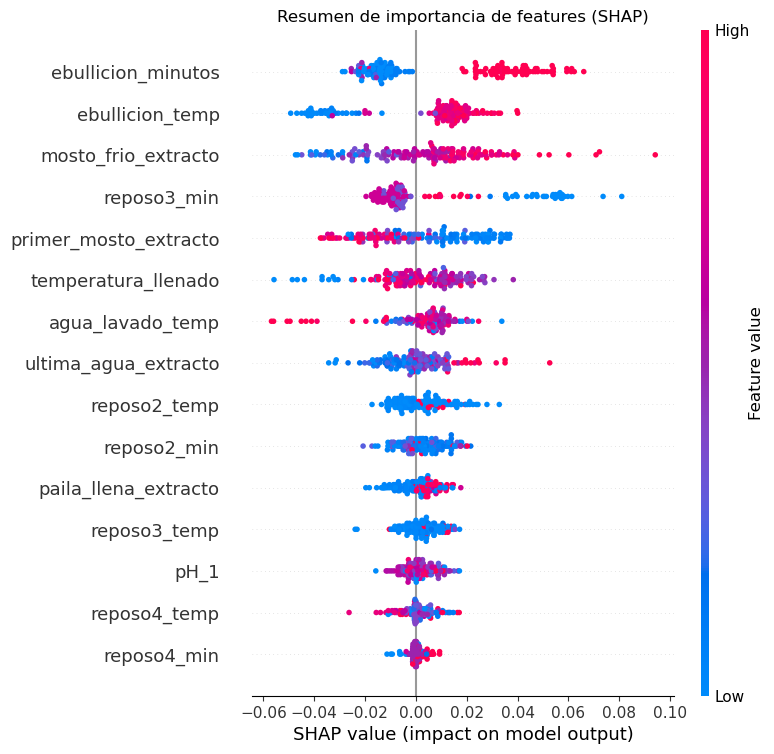

<Figure size 640x480 with 0 Axes>

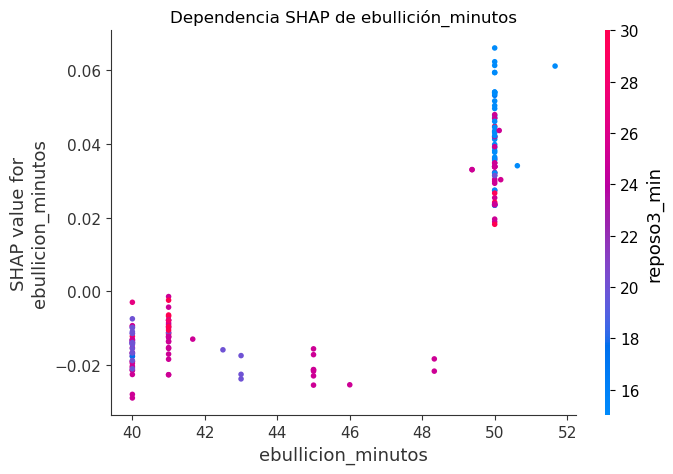

In [16]:
""" Visualización SHAP de XGBoost
Importancia Global de Features y Dependencia de "ebullición_minutos" """

# Crear el objeto TreeExplainer
explainer = shap.TreeExplainer(xgb)

# Calcular valores SHAP para el conjunto de prueba
shap_values = explainer.shap_values(X_test)

# Gráfico resumen de SHAP
shap.summary_plot(shap_values, X_test, show=False)
plt.title('Resumen de importancia de features (SHAP)')
plt.show()

# Dependencia de la variable más importante (ebullición_minutos)
plt.figure()
shap.dependence_plot('ebullicion_minutos', shap_values, X_test, show=False)
plt.title('Dependencia SHAP de ebullición_minutos')
plt.show()

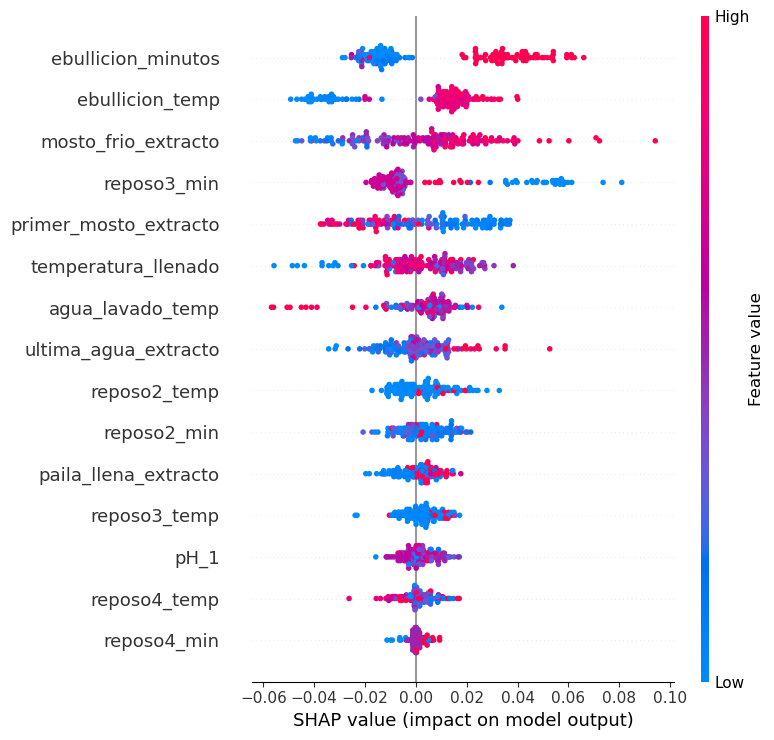

<Figure size 640x480 with 0 Axes>

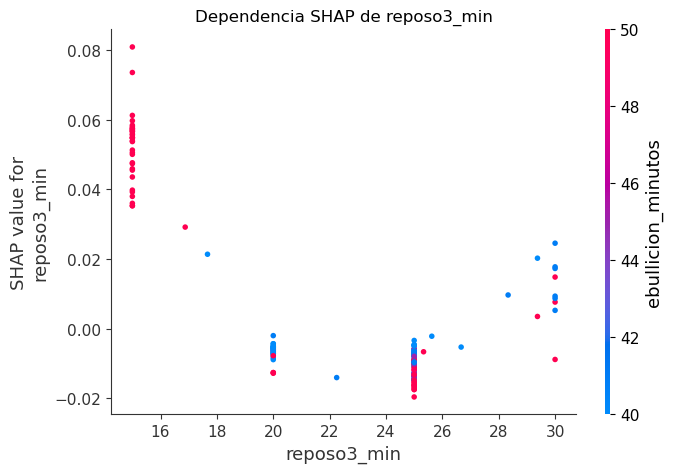

<Figure size 640x480 with 0 Axes>

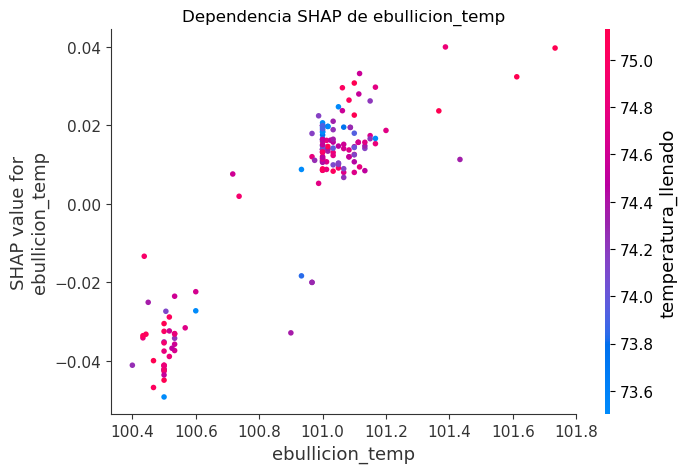

<Figure size 640x480 with 0 Axes>

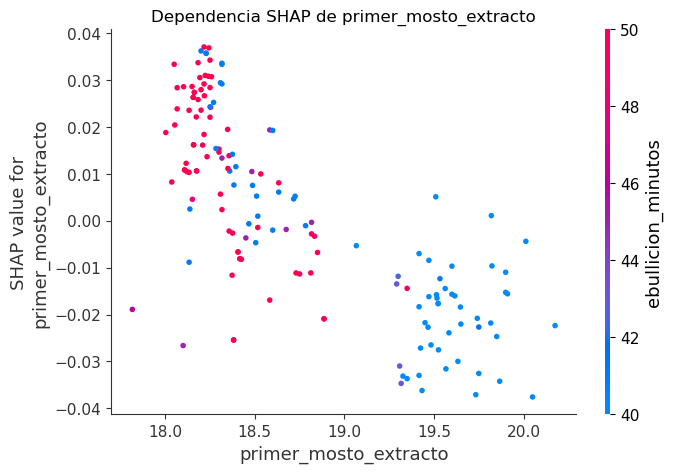

<Figure size 640x480 with 0 Axes>

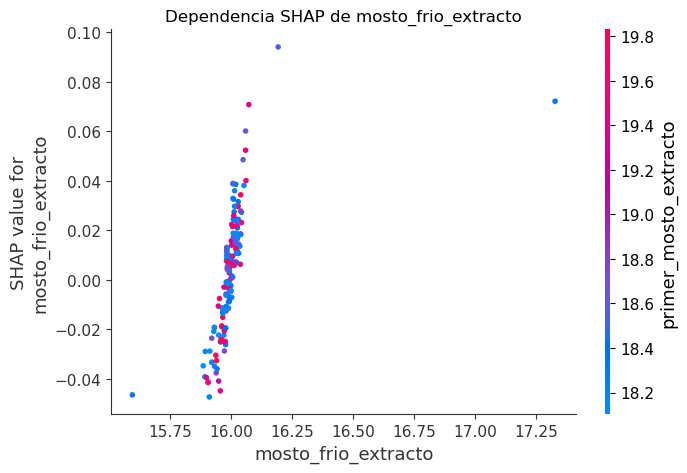

In [17]:
"""Interpretación de XGBoost con SHAP: Gráfico Resumen y Dependence Plots de Características Clave"""

# Crear el explicador
explainer = shap.TreeExplainer(xgb)

# Calcular valores SHAP
shap_values = explainer.shap_values(X_test)

# Summary plot (global)
shap.summary_plot(shap_values, X_test)

# Dependence plots para las top-4 features
for feature in ['reposo3_min', 'ebullicion_temp', 'primer_mosto_extracto', 'mosto_frio_extracto']:
    plt.figure()
    shap.dependence_plot(feature, shap_values, X_test, show=False)
    plt.title(f'Dependencia SHAP de {feature}')
    plt.show()


In [18]:
""" Serialización del modelo entrenado a un archivo binraio en disco"""

import joblib
joblib.dump(xgb, 'xgb_end_model.pkl')

['xgb_end_model.pkl']